# Transfer Learning for Jet Tagging in Particle Physics: GNN

This is the second accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

### Stage 2: Transfer Learning via GNN

The current state-of-the-art jet tagging model uses a Graph Neural Network architecture. Our second goal is then to build a Teacher and a Student GNN and implement transfer learning similarly to what we did with the FCCN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn as nn
import seaborn as sns
from preprocess import *
from helper import *

sns.set_theme()
plt.style.use("seaborn-v0_8")

Similarly to the first notebook, we will start by loading in the data and preprocessing. Note that since we are now working with *graphs*, the preprocessing steps will differ significantly!

In [2]:
cons_data, cons_labels, cons_weights, cons_features = get_data("./data/reduced_atlas_dataset.h5", attribute="constituents")

# TODO: INCLUDE WEIGHTS IN MODEL

print("---------- Constituent-level data ----------------", "\n")
print("Data shape [input_size, num_features, num_constituents]:", cons_data.shape, "\n")
print("Feature names:", cons_features)
print("Feature names (human-readable):", [human_feature(f) for f in cons_features])

---------- Constituent-level data ---------------- 

Data shape [input_size, num_features, num_constituents]: (10000, 4, 80) 

Feature names: ['fjet_clus_pt' 'fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_E']
Feature names (human-readable): ['constituent transverse momentum', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent energy']


To implement our GNN, we then need to form graphs using our data. We will do so using the k-nearest-neighbors algorithm.

In [3]:
from preprocess import prepare_graphs

graphs = prepare_graphs(cons_data, cons_labels, k=8)

#### Visualize

We can visualize the graphs we just created!

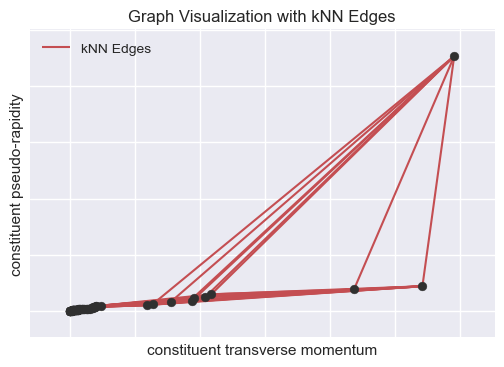

In [4]:
from visualize import visualize_graph

visualize_graph(graphs[10], x_axis='fjet_clus_pt', y_axis='fjet_clus_eta')

#### Build the Teacher GNN

Let's build the Teacher GNN and train it on the high-resolution data:

In [5]:
from model import TeacherGNN
from preprocess import split_graphs
from model import train_one_epoch_gnn, test_gnn

# prepare data
train_dataset, val_dataset, test_dataset = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# initialize model
teacher_gnn = TeacherGNN().to(device)
optimizer = torch.optim.Adam(teacher_gnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
acc_metric = torchmetrics.classification.BinaryAccuracy()

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

# start training
num_epochs = 10
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch_gnn(teacher_gnn, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test_gnn(teacher_gnn, device, val_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

/Users/jmduchar/anaconda3/envs/final_project/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


KeyboardInterrupt: 

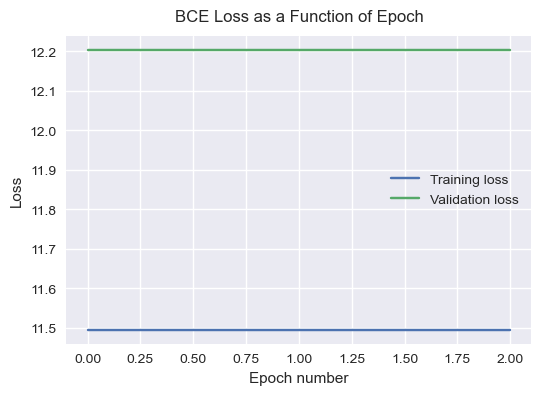

In [6]:
from visualize import plot_accuracy, plot_loss

plot_loss(loss_list, val_loss_list)

In [ ]:
plot_accuracy(acc_list, val_acc_list)